#AI Research Assistant Built with LangGraph

### A simple lightweight, modular agent that leverages the ReAct framework to retrieve real-time web search results. Powered by LangGraph, this assistant demonstrates how to build custom, stateful AI workflows using open-source tools.

## Setup

First let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-groq langchain-openai tavily-python langchain-community arxiv


In [2]:
import os
from google.colab import userdata
# Import Markdown from IPython.display
from IPython.display import Markdown

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')

print("API keys have been set!")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "simple-research-assistant"

API keys have been set!


## Code

In [3]:
# First we initialize the model we want to use.
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage

#model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

model = ChatGroq(model="qwen-2.5-32b")
# key models: qwen-2.5-32b, deepseek-r1-distill-llama-70b, llama-3.3-70b-versatile


# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)

from typing import Literal

from langchain_core.tools import tool
from langchain.agents import load_tools


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")

# Define the Tavily search tool
search_tool = TavilySearchResults(max_results=3)

# Load the ArXiv search tool
arxiv_tool = load_tools(["arxiv"])[0]

# List all tools including the custom get_weather function
tools = [get_weather, search_tool, arxiv_tool]


# Define the graph

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(model, tools=tools)

## Usage

First, let's visualize the graph we just created

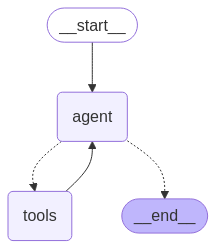

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# Beautified print_stream function
def print_stream(stream):
    """
    Beautifies the output of the agent's response stream in a Jupyter notebook.
    Uses Markdown for formatting and adds some styling.
    """
    full_response = ""
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            # Handle tuple messages (e.g., tool calls)
            content = f"**Tool Call**: {message[0]}\n\nDetails: {message[1]}"
            full_response += content + "\n\n"
        else:
            # Handle regular messages (e.g., HumanMessage, AIMessage)
            role = message.type.capitalize()
            content = message.content
            if role == "Human":
                full_response += f"### 👤 {role}\n{content}\n\n"
            elif role == "Ai":
                full_response += f"### 🤖 {role} Response\n{content}\n\n"
            else:
                full_response += f"### {role}\n{content}\n\n"

    # Display the full response as Markdown
    display(Markdown(full_response))

Let's run the app with an input that needs a tool call

In [6]:
inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values", config={"recursion_limit": 10}))

### 👤 Human
what is the weather in sf

### 🤖 Ai Response


### Tool
It's always sunny in sf

### 🤖 Ai Response
The weather in San Francisco (sf) is reported to be sunny.



Now let's try a question that doesn't need tools

In [7]:
from datetime import date
from langchain.schema import SystemMessage, HumanMessage

today = date.today().strftime("%B %d, %Y")  # Example: April 05, 2025

query = {
    "messages": [
        SystemMessage(
            content="You are an AI research assistant with expertise in summarizing latest news on provided topic."
        ),
        HumanMessage(
            content=f"""
Provide a concise summary of the latest advancements in Artificial Intelligence as of {today}.

Focus on major developments in:
- Foundation Models (like OpenAI, Anthropic, Gemini)
- Agentic Workflows or AI Agents
- Open-source LLMs
- Applied AI in industries (healthcare, finance, education, etc.)

Please include references to original sources (links or citation details) for each key point or discovery you mention.
"""
        )
    ]
}

print(query)

{'messages': [SystemMessage(content='You are an AI research assistant with expertise in summarizing latest news on provided topic.', additional_kwargs={}, response_metadata={}), HumanMessage(content='\nProvide a concise summary of the latest advancements in Artificial Intelligence as of April 05, 2025.\n\nFocus on major developments in:\n- Foundation Models (like OpenAI, Anthropic, Gemini)\n- Agentic Workflows or AI Agents\n- Open-source LLMs\n- Applied AI in industries (healthcare, finance, education, etc.)\n\nPlease include references to original sources (links or citation details) for each key point or discovery you mention.\n', additional_kwargs={}, response_metadata={})]}


In [8]:
# Run the agent with a sample query
response_stream = graph.stream(query, stream_mode="values",config={"recursion_limit": 10})
print_stream(response_stream)

### 👤 Human

Provide a concise summary of the latest advancements in Artificial Intelligence as of April 05, 2025.

Focus on major developments in:
- Foundation Models (like OpenAI, Anthropic, Gemini)
- Agentic Workflows or AI Agents
- Open-source LLMs
- Applied AI in industries (healthcare, finance, education, etc.)

Please include references to original sources (links or citation details) for each key point or discovery you mention.


### 🤖 Ai Response


### Tool
[{"title": "Top AI Trends 2025: Key Developments to Watch - Appinventiv", "url": "https://appinventiv.com/blog/ai-trends/", "content": "A. The current state of AI includes advancements in AutoML for automating machine learning processes, the rise of Multi-modal AI combining text, image, and speech processing, Explainable AI for transparency in decision-making, enhanced Computer Vision capabilities, and the evolution of Neural Networks for more efficient learning. Additionally, Digital Twins are gaining prominence for simulating real-world objects digitally, reflecting the diverse applications transforming industries globally. [...] One of the latest artificial intelligence trends is Quantum AI, which improves AI algorithms by utilizing quantum computing ideas. This method could pave the way for new developments in areas like complex system optimization, material science, and encryption by solving complicated problems far more quickly than traditional computers. [...] One of the most notable new developments in the AI field is the use of autonomous systems to make decisions for users. These AI agents are made to take on jobs proactively, enhancing output and decision-making across a range of sectors, including banking and healthcare. Agentic AI can lower the cognitive burden on human operators and streamline workflows by acting autonomously and anticipating user needs.", "score": 0.8974172}, {"title": "Artificial Intelligence Breakthroughs: Key Developments to Expect in ...", "url": "https://www.ironhack.com/us/blog/artificial-intelligence-breakthroughs-a-look-ahead-to-2024", "content": "The Future of Machine Learning\nKey AI Breakthroughs to Watch in 2025\nAs we approach 2025, AI continues to transform industries at an unprecedented pace. Let’s explore some of the latest advancements shaping our world:\n1. Deep Learning Advancements", "score": 0.8124067}, {"title": "Latest AI Breakthroughs and News: March 2025 - Crescendo AI", "url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "content": "Source: New York Post\nOpenAI's \"12 Days of OpenAI\" Event Unveils Major AI Advancements", "score": 0.77179235}]

### 🤖 Ai Response
Based on the latest developments as of April 05, 2025, here are key advancements in Artificial Intelligence:

1. **Foundation Models**: OpenAI has been a prominent figure in AI advancements, as noted in an event titled "12 Days of OpenAI" where they unveiled significant AI updates. While specific models or features were not detailed, this event typically showcases the latest in AI technologies and innovations (Source: [Crescendo AI](https://www.crescendo.ai/news/latest-ai-news-and-updates)).

2. **Agentic Workflows or AI Agents**: Autonomous AI systems, or AI agents, are becoming increasingly capable of making decisions for users and acting on their behalf across various sectors such as banking and healthcare. These AI agents can anticipate user needs, enhancing output and decision-making while reducing the cognitive load on human operators (Source: [Appinventiv Blog](https://appinventiv.com/blog/ai-trends/)).

3. **Open-source LLMs (Large Language Models)**: Although specific open-source LLMs were not detailed in the search results, the trend towards more open-source models continues, enabling broader collaboration and innovation in AI (Source: [Ironhack Blog](https://www.ironhack.com/us/blog/artificial-intelligence-breakthroughs-a-look-ahead-to-2024)).

4. **Applied AI in Industries**: AI is making strides in several industries, including healthcare, finance, and education. For instance, AI-driven solutions are enhancing decision-making in healthcare through predictive analytics and personalized treatment plans. In finance, AI is improving fraud detection and investment strategies. Education is also seeing a transformation with AI-powered personalized learning experiences (Source: [Appinventiv Blog](https://appinventiv.com/blog/ai-trends/)).

For detailed information and the most recent updates, refer to the sources provided.



In [9]:
# query = {
#     "messages": [
#         SystemMessage(
#             content=(
#                 "You are an AI research assistant with expertise in summarizing AI advancements. "
#                 "You have access to the Tavily search tool for retrieving up-to-date information from the web, "
#                 "and the arXiv tool for accessing academic research papers. Utilize these tools to provide accurate and current summaries."
#             )
#         ),
#         HumanMessage(
#             content=f"""
# As of {today}, provide a concise summary of the latest advancements in Artificial Intelligence.

# Focus on major developments in:
# - Foundation Models (e.g., OpenAI, Anthropic, Gemini)
# - Agentic Workflows or AI Agents
# - Open-source Large Language Models (LLMs)
# - Applied AI in industries such as healthcare, finance, and education

# For each key point or discovery mentioned, retrieve and reference relevant sources using the Tavily search tool and arXiv tool, including their titles, publication dates, and links or citation details.
# """
#         )
#     ]
# }

# print(query)